In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Dropout, Flatten, Rescaling, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import datasets, layers, models
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
import joblib


In [2]:
# Define the base directory where images are stored
data_dir = "path/to/dataset"

# Define class labels
classes = {'Bengin case', 'Malignant case', 'Normal case'}

# Initialize empty lists for images and labels
images = []
labels = []

image_size = 224

# Loop through each class directory
for class_name in classes:
    # Get the path to the current class directory
    class_dir = os.path.join(data_dir, class_name)

    # Loop through each image file in the class directory
    for filename in os.listdir(class_dir):
        # Get the full path to the image file
        image_path = os.path.join(class_dir, filename)

        # Load the image using OpenCV or PIL (adjust as needed)
        image = cv2.imread(image_path)  # Replace with your preferred image loading function
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (image_size, image_size))
        #image = np.expand_dims(image, axis=-1)
        # Append the image and its corresponding label to the lists
        images.append(image)
        labels.append(class_name)

label_dict = {"Bengin case": 0, "Malignant case": 1, "Normal case": 2}
encoded_labels = [label_dict[label] for label in labels]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.30, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10/(1-0.10), random_state=42)


# Convert lists to NumPy arrays for further processing
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)

# You can now use X_train, X_test, y_train, y_test for your machine learning tasks

print("Training data size:", len(X_train))
print("Testing data size:", len(X_test))
print("Validation data size:", len(X_val))

Training data size: 756
Testing data size: 366
Validation data size: 95


In [3]:
X_train.shape

(756, 224, 224, 3)

In [4]:
X_train, X_test, X_val= X_train / 255.0, X_test / 255.0, X_val / 255.0 # Rescale it to 0-1

In [5]:
from collections import Counter

# Create a dictionary to store class counts
train_class_counts = Counter()

# Count images for each class
for image_path in y_train:
    #class_name = image_path.split("/")[0]
    class_name = str(image_path).split("/")[0]
    train_class_counts[class_name] += 1

# Print the class counts
print("Number of training images per class:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count}")

Number of training images per class:
1: 354
0: 158
2: 244


In [6]:
# Create a dictionary to store class counts
test_class_counts = Counter()

# Count images for each class
for image_path in y_test:
    #class_name = image_path.split("/")[0]
    class_name = str(image_path).split("/")[0]
    test_class_counts[class_name] += 1

# Print the class counts
print("Number of testing images per class:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count}")

Number of testing images per class:
2: 140
0: 68
1: 158


In [7]:
# Create a dictionary to store class counts
test_class_counts = Counter()

# Count images for each class
for image_path in y_val:
    #class_name = image_path.split("/")[0]
    class_name = str(image_path).split("/")[0]
    test_class_counts[class_name] += 1

# Print the class counts
print("Number of validation images per class:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count}")

Number of validation images per class:
1: 49
0: 14
2: 32


As observed from the split data, we can conclude that there are imbalance in class

Custom_CNN Model

In [14]:
initializer =keras.initializers.HeNormal(seed = 123) # Weight initializer

cnn_model = keras.models.Sequential([

  keras.layers.Conv2D(filters = 128, kernel_size = (5,5), strides = (2,2), activation = 'relu', input_shape = (image_size, image_size, 3)), # input layer with a convolutional layer
  keras.layers.MaxPool2D(pool_size = (3,3), strides = (2,2)), # maxpooling layer

  # Second convolutional layer
  keras.layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1),padding = 'same', activation = 'relu', kernel_initializer= initializer, kernel_regularizer = tf.keras.regularizers.l2(l=0.01)),
  keras.layers.MaxPool2D(pool_size = (3,3), strides = (2,2)),

  # Third convolutional layer
  keras.layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu' , kernel_initializer= initializer, kernel_regularizer = tf.keras.regularizers.l2(l=0.01)),
  keras.layers.MaxPool2D(pool_size = (2,2), strides = (1,1)),

  keras.layers.Flatten(), # flatten the 3D tensors into a 1D vector to feed into the fully connected layer

  # First fully connected layer
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dropout(0.50, seed = 123),

  # Output layer
  keras.layers.Dense(3, activation='softmax') # softmax is used when there are more than 2 classification classes
])

In [15]:
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 110, 110, 128)     9728      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 54, 54, 64)        73792     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 26, 26, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        18464     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 25, 25, 32)       

In [16]:
# Model Compilation
learning_rate = 0.001 # step size to take after calculating loss
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate) # set optimizer and learning rate

cnn_model.compile(
                  loss='sparse_categorical_crossentropy', # loss function use for non numeric multi-class classification
                  optimizer=optimizer,
                  metrics=["accuracy"]
)

history = cnn_model.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=10, shuffle = True, batch_size=8)  # Train for 10 epochs with a batch size of 8

Epoch 1/10
95/95 [==============================] - 4s 26ms/step - loss: 1.9860 - accuracy: 0.4802 - val_loss: 1.3170 - val_accuracy: 0.5789
Epoch 2/10
95/95 [==============================] - 3s 28ms/step - loss: 1.1338 - accuracy: 0.6243 - val_loss: 0.7884 - val_accuracy: 0.7684
Epoch 3/10
95/95 [==============================] - 1s 14ms/step - loss: 0.7850 - accuracy: 0.7540 - val_loss: 0.5302 - val_accuracy: 0.8632
Epoch 4/10
95/95 [==============================] - 1s 13ms/step - loss: 0.5179 - accuracy: 0.8664 - val_loss: 0.3519 - val_accuracy: 0.9263
Epoch 5/10
95/95 [==============================] - 1s 13ms/step - loss: 0.3991 - accuracy: 0.8796 - val_loss: 0.3060 - val_accuracy: 0.9368
Epoch 6/10
95/95 [==============================] - 1s 13ms/step - loss: 0.2926 - accuracy: 0.9286 - val_loss: 0.2540 - val_accuracy: 0.9263
Epoch 7/10
95/95 [==============================] - 1s 14ms/step - loss: 0.2470 - accuracy: 0.9365 - val_loss: 0.1879 - val_accuracy: 0.9474
Epoch 8/10
95

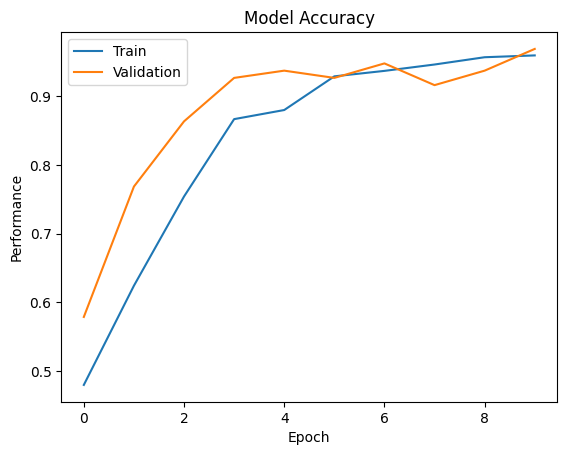

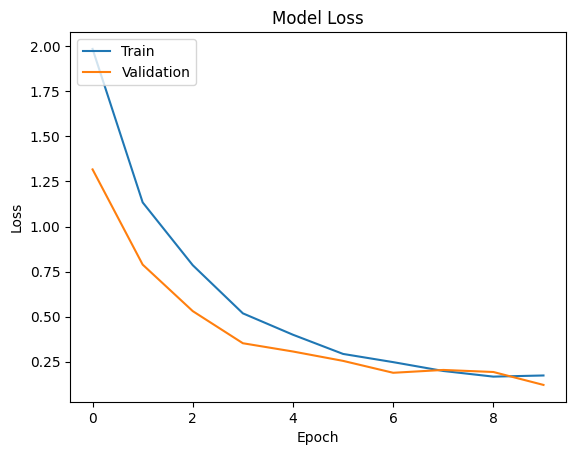

In [19]:
plt.plot(history.history['accuracy']) # plot training accuracy
plt.plot(history.history['val_accuracy']) # plot validation accuracy
plt.title('Model Accuracy') # title of the graph
plt.ylabel('Performance')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show() # construct the plot

plt.plot(history.history['loss']) # plot training loss
plt.plot(history.history['val_loss']) # plot validation loss
plt.title('Model Loss') # title of the graph
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show() # construct the plot

In [18]:
cnn_y_pred = cnn_model.predict(X_test) # predict on test data using the FC
cnn_y_pred = np.argmax(cnn_y_pred, axis = -1)
print(classification_report(y_test, cnn_y_pred)) # check the report

12/12 [==============================] - 1s 39ms/step
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        68
           1       0.99      1.00      0.99       158
           2       0.96      0.95      0.95       140

    accuracy                           0.96       366
   macro avg       0.96      0.95      0.96       366
weighted avg       0.96      0.96      0.96       366



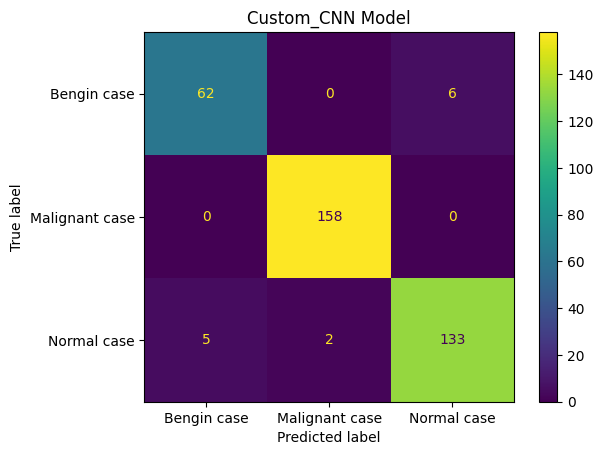

In [20]:
cm = metrics.confusion_matrix(y_test, cnn_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = {'Bengin case':0, 'Malignant case':1, 'Normal case':2})

cm_display.plot()
plt.title("Custom_CNN Model")
plt.show()

In [21]:
model_feat = Model(inputs=cnn_model.input,outputs=cnn_model.get_layer('flatten_2').output)

In [22]:
model_feat.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6_input (InputLayer  [(None, 224, 224, 3)]     0         
 )                                                               
                                                                 
 conv2d_6 (Conv2D)           (None, 110, 110, 128)     9728      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 54, 54, 64)        73792     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 26, 26, 64)        0         
 g2D)                                                            
                                                             

In [23]:
feature_extractor = model_feat.predict(X_train) # extract feature from X_train

24/24 [==============================] - 1s 24ms/step


CNN-RF Model

In [24]:
Rf_X_train = feature_extractor # store it in a new variable to train RF

RF_model = RandomForestClassifier(n_estimators = 200, random_state=123)
RF_model.fit(Rf_X_train, y_train) # Training the RF model with the extracted feature

RandomForestClassifier(n_estimators=200, random_state=123)

In [25]:
# Extract features from test data
Rf_X_test = model_feat.predict(X_test)

# Make predictions on the test data
Rf_y_pred = RF_model.predict(Rf_X_test)

# Evaluate the model performance (e.g., accuracy)
print(classification_report(y_test, Rf_y_pred))

12/12 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        68
           1       0.96      1.00      0.98       158
           2       0.99      0.97      0.98       140

    accuracy                           0.98       366
   macro avg       0.98      0.97      0.98       366
weighted avg       0.98      0.98      0.98       366



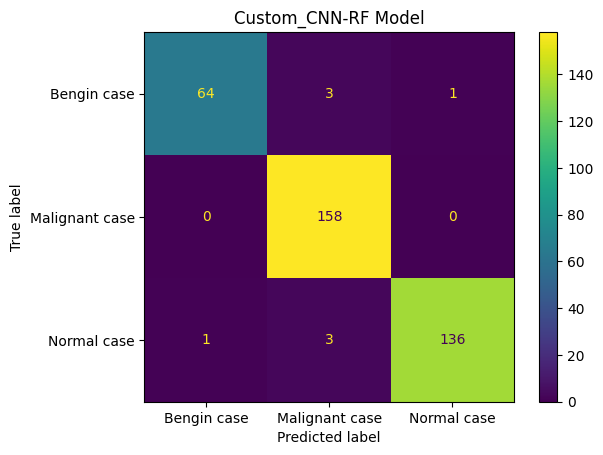

In [26]:
cm = metrics.confusion_matrix(y_test, Rf_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = {'Bengin case':0, 'Malignant case':1, 'Normal case':2})

cm_display.plot()
plt.title("Custom_CNN-RF Model")
plt.show()

10-Fold Cross-Validation with Custom_CNN-RF Model

In [ ]:
# So we will use it on K-Fold Cross Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np

X = np.array(images)
y = np.array(encoded_labels)

X_feature = model_feat.predict(X) # extract feature from X_train

# Specify the number of folds (e.g., K=5 for 5-fold cross-validation)
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform K-fold cross-validation_
cross_val_results = cross_val_score(RF_model, X_feature, y, cv=k_fold, scoring='accuracy')

# Print the cross-validation results
print("Cross-validation results:", cross_val_results)
print("Mean accuracy:", np.mean(cross_val_results))

39/39 [==============================] - 26s 653ms/step
Cross-validation results: [1.         0.99180328 0.97540984 1.         0.97540984 0.98360656
 0.97540984 0.99173554 0.97520661 0.99173554]
Mean accuracy: 0.9860317030212709


Saving the model

In [27]:
# Save the model architecture and weights to a HDF5 file
model_feat.save('/content/drive/MyDrive/custom_cnn_feature_extractor_final.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
joblib.dump(RF_model, '/content/drive/MyDrive/RF_model_final.pkl')

['/content/drive/MyDrive/RF_model_final.pkl']